### 1. NLL versus Cross-Entropy losses

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# Raw scores before applying softmax
scores = torch.randn(3, 5)
scores

tensor([[ 0.5069, -0.7116,  0.1204, -0.9046, -0.9859],
        [-0.6540, -0.8190,  1.6131, -0.9750,  0.5351],
        [ 2.3399, -1.4146, -0.7097, -0.4226,  0.5737]])

In [3]:
# True "ys" (word indicies)
y_true = torch.tensor([1, 4, 3])
y_true

tensor([1, 4, 3])

In [4]:
# Cross Entropy Loss (automatically applies softmax + log + NLL)
cross_entropy_loss = nn.CrossEntropyLoss()
loss_ce = cross_entropy_loss(scores, y_true)
print("Cross Entropy Loss:", loss_ce.item())

Cross Entropy Loss: 2.2309858798980713


In [5]:
# Negative Log Likelihood Loss (requires log_softmax on logits beforehand)
# Apply log_softmax to logits to get log probabilities
log_probs = F.log_softmax(scores, dim=1)
nll_loss = nn.NLLLoss()
loss_nll = nll_loss(log_probs, y_true)
print("Negative Log Likelihood Loss:", loss_nll.item())

Negative Log Likelihood Loss: 2.2309858798980713


### 2. Top k sampling 

In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
np.random.seed(42)

In [8]:
vocab = ["apple", "banana", "cherry", "date", "elderberry", "fig", "grape", "honeydew", "kiwi", "lemon"]
probabilities = np.array([0.15, 0.12, 0.10, 0.08, 0.05, 0.18, 0.07, 0.09, 0.04, 0.12])
assert len(vocab) == len(probabilities)

In [9]:
sorted_indices = np.argsort(-probabilities)
sorted_vocab = [vocab[i] for i in sorted_indices]
sorted_probs = probabilities[sorted_indices]
print([(v, p) for v, p in zip(sorted_vocab, sorted_probs)])

[('fig', 0.18), ('apple', 0.15), ('banana', 0.12), ('lemon', 0.12), ('cherry', 0.1), ('honeydew', 0.09), ('date', 0.08), ('grape', 0.07), ('elderberry', 0.05), ('kiwi', 0.04)]


In [10]:
def top_k_sampling(vocab, probabilities, k=3):
    top_k_indices = np.argsort(-probabilities)[:k]
    top_k_vocab = [vocab[i] for i in top_k_indices]
    top_k_probs = probabilities[top_k_indices]
    top_k_probs /= top_k_probs.sum()
    return top_k_vocab, top_k_probs

In [11]:
top_k_vocab, top_k_probs = top_k_sampling(vocab, probabilities, k=3)
top_k_vocab
top_k_probs

array([0.4       , 0.33333333, 0.26666667])

In [12]:
sampled_word = np.random.choice(top_k_vocab, p=top_k_probs)
sampled_word

'fig'

### 3. Temperature sampling 

In [13]:
def temperature_sampling(vocab, probabilities, temperature=1.0):
    adjusted_probs = np.exp(np.log(probabilities) / temperature) #Log for numerical stability 
    adjusted_probs /= adjusted_probs.sum()  # normalize to a probability 
    return vocab, adjusted_probs

In [14]:
def plot_temp_scaling(vocab, probabilities, temperature=1.0): 
    vocab, adjusted_probs = temperature_sampling(vocab, probabilities, temperature=temperature)
    plt.figure()
    plt.bar(vocab, adjusted_probs)
    plt.xlabel('Words')
    plt.ylabel('Adjusted Probability')
    plt.title(f'Temperature Sampling (Temperature = {temperature})')
    plt.xticks(rotation=45)
    plt.show()

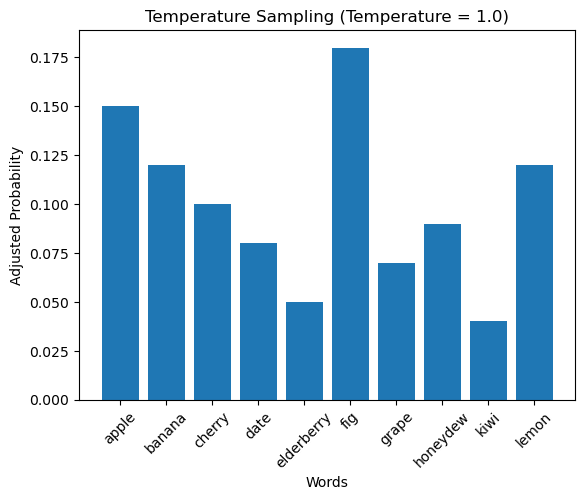

In [15]:
plot_temp_scaling(vocab, probabilities,  temperature=1.0)

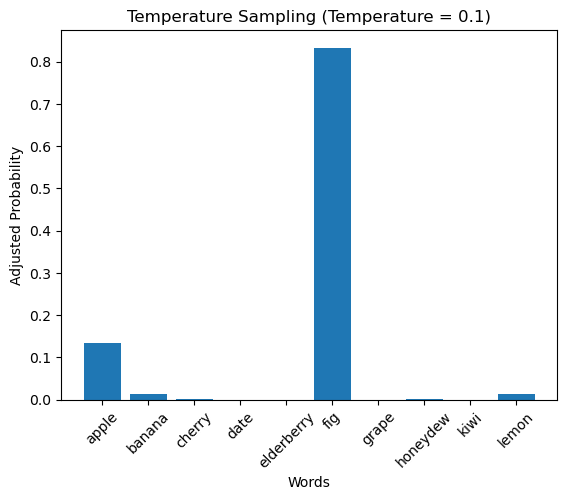

In [16]:
plot_temp_scaling(vocab, probabilities,  temperature=0.1)

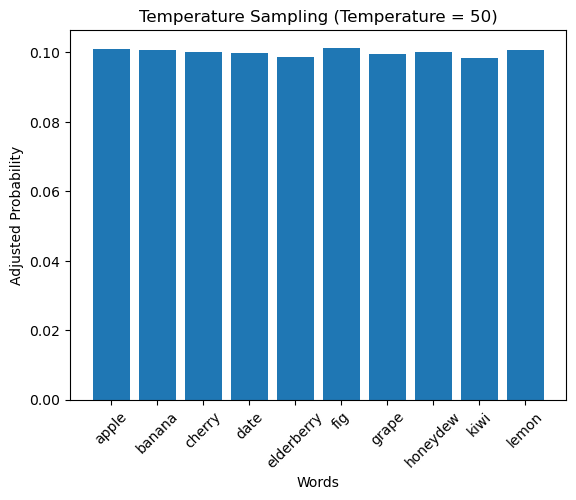

In [17]:
plot_temp_scaling(vocab, probabilities,  temperature=50)

### 4. Models from huggingface's transformers

In [18]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

In [19]:
model_name = "distilgpt2"  # A smaller, efficient version of GPT-2
tokenizer = AutoTokenizer.from_pretrained(model_name, clean_up_tokenization_spaces=True)
model = AutoModelForCausalLM.from_pretrained(model_name)
# Set the pad_token_id to eos_token_id to handle padding
model.config.pad_token_id = model.config.eos_token_id

In [20]:
def generate_text(prompt, temperature=1.0, max_length=50):
    inputs = tokenizer(prompt, return_tensors="pt")
    #inputs["attention_mask"] = inputs["attention_mask"]

    output = model.generate(
        **inputs,
        max_length=max_length,   # length of output
        do_sample=True,
        temperature=temperature, # temperature 
        top_k=10,                # top-k sampling
    )

    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    return generated_text

In [21]:
# Halloween-themed prompt
prompt = "Once upon a midnight dreary, while I pondered"

In [22]:
temp = 0.5
print(f"\n--- Temperature: {temp} ---")
print(generate_text(prompt, temperature=temp))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



--- Temperature: 0.5 ---
Once upon a midnight dreary, while I pondered the question of the future, I found myself pondering the future, wondering if I could be the first person to ever make the journey.


I was not sure what to make


In [23]:
temp = 1.0
print(f"\n--- Temperature: {temp} ---")
print(generate_text(prompt, temperature=temp))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



--- Temperature: 1.0 ---
Once upon a midnight dreary, while I pondered the possibility, it was clear to me that we were going to have to find out what exactly we were doing.
I thought it would be interesting to see if we could learn from this


In [24]:
temp = 1.5
print(f"\n--- Temperature: {temp} ---")
print(generate_text(prompt, temperature=temp))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



--- Temperature: 1.5 ---
Once upon a midnight dreary, while I pondered a small amount of wine and beer and some coffee, I thought: Why would this drink matter? Well it is the only thing left for me to do with my daily life.




In [25]:
temp = 3.0
print(f"\n--- Temperature: {temp} ---")
print(generate_text(prompt, temperature=temp))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



--- Temperature: 3.0 ---
Once upon a midnight dreary, while I pondered for my future, the next question was how I should proceed, as if to give some more guidance.
This, however, made a very simple, easy decision: to do what we


In [26]:
temp = 20.0
print(f"\n--- Temperature: {temp} ---")
print(generate_text(prompt, temperature=temp))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



--- Temperature: 20.0 ---
Once upon a midnight dreary, while I pondered a bit of something in a dark cave that seemed to me quite a little, the sound of the creature coming to mind. It seemed quite like the creature might not seem too scary and I
